In [1]:
import scipy.io
import mne
from scipy.signal import butter, filtfilt
import os
import numpy as np
from scipy import stats

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


from matplotlib import pyplot as plt
mne.set_log_level('error')


In [2]:
data_root = 'C:/Data/UHD_EEG/'
subjects = ['S1', 'S2', 'S3', 'S4', 'S5']
dominant_hand = ['left','right','right','right','right']

mapping = {0: "No instruction", 1: "Rest", 2: "thumb", 3: "index", 4: "middle", 5: "ring", 6: "little"}

not_ROI_channels = ['c255', 'c256', 'c254', 'c251', 'c239', 'c240', 'c238', 'c235', 'c224', 'c222', 'c223', 'c219', 'c220', 'c221', 'c215', 'c216', 'c217', 'c213', 'c212', 'c211', 'c210', 'c209', 'c112', 'c110', 'c107', 'c108', 'c103', 'c104', 'c105', 'c101', 'c100', 'c99', 'c98', 'c97', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c14', 'c15', 'c16', 'c23', 'c29', 'c26', 'c17', 'c18', 'c20', 'c19', 'c21', 'c24', 'c22', 'c25', 'c28', 'c33', 'c35', 'c38', 'c42', 'c81', 'c34', 'c37', 'c41', 'c45', 'c36', 'c40', 'c44', 'c39', 'c43', 'c145', 'c147', 'c150', 'c154', 'c157', 'c153', 'c149', 'c146', 'c93', 'c159', 'c156', 'c152', 'c148', 'c95', 'c160', 'c158', 'c155', 'c151', 'c96', 'c202', 'c198', 'c195', 'c193']

In [3]:
def get_montage(hemishpere):
    mat = scipy.io.loadmat(os.path.join(data_root, 'montage', f'montage_256_{hemishpere}_hemisphere.mat'))
    return mat['pos_256']

left_handed_montage = get_montage('right')
right_handed_montage = get_montage('left')

In [4]:
def load_run(subject_id, run, describe=True):
    subject = subjects[subject_id]
    mat = scipy.io.loadmat(os.path.join(data_root, 'rawdata', subject, run))
    data = mat['y'][1:]  # remove timestamp
    ch_names = [f'c{i}' for i in range(1, 257)] + ['STIM']
    info = mne.create_info(ch_names=ch_names, sfreq=mat['SR\x00'][0][0])

    raw = mne.io.RawArray(data, info)
    ch_types = {ch: 'eeg' if ch != 'STIM' else 'stim' for ch in ch_names}
    raw.set_channel_types(ch_types)

    events = mne.find_events(raw, stim_channel='STIM')
    annot_from_events = mne.annotations_from_events(events, event_desc=mapping, sfreq=raw.info['sfreq'])
    raw.set_annotations(annot_from_events)
    raw.drop_channels(['STIM'])

    montage_positions = left_handed_montage if dominant_hand[subject_id] == 'left' else right_handed_montage
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, montage_positions)), coord_frame='head')
    raw.set_montage(montage)

    if describe:
        raw.describe()
    return raw


In [5]:
def load_subject(subject_id, describe = True):
    runs = []
    run_files = os.listdir(os.path.join(data_root, 'rawdata', subjects[subject_id]))
    for file in run_files:
        runs.append(load_run(subject_id, file, describe))
    return runs

In [6]:
raw_runs = load_subject(subject_id = 0, describe = False)

In [39]:
'''
Next, bad channels
and runs were identified based on EEG data during the task
period. 
'''

def find_bad_channels(orig, flat_threshold=1e-2, z_threshold = 6):
    """
    Identify and drop bad channels based on their standard deviation and z-score.
    
    Parameters:
    :param raw: Raw EEG data (MNE Raw object)
    threshold (float): Threshold for identifying bad channels (default: 3)

    Returns:
    bad_channels (list): List of bad channel indices
    """

    raw = orig.copy()
    raw.set_eeg_reference('average', projection=False)

    raw = raw.filter(8, 25,  fir_design='firwin')

    bad_channels = []

    # Find flat channels based on the threshold
    variance = np.var(raw.get_data('eeg'), axis=1)
    flat_channels = [ch_name for ch_name, var in zip(raw.ch_names, variance) if var < flat_threshold]
    # Print the list of flat channels
    print("Flat channels found: ", flat_channels)
    bad_channels.extend(flat_channels)

    data = raw.get_data('eeg')

    bad_channels = []


    mean_powers = np.mean((data-data.mean(axis=1, keepdims=True))**2, axis=1)
    log_mean_powers = np.log(mean_powers)
    z_scores = (log_mean_powers - log_mean_powers.mean()) / log_mean_powers.std()

    bad_channel_indices = np.where(np.abs(z_scores) > z_threshold)[0].tolist()
    
    print("Bad channels found: ", bad_channel_indices)
    bad_channels.extend(bad_channel_indices)
    return [raw.ch_names[i] for i in bad_channels]


In [40]:
def resample(run):
    '''
    The raw EEG recordings were first down-sampled from
    600 to 200 Hz (resample)
    '''
    run = run.resample(200)
    return run

def notch(run):
    '''
    notch-filtered at 60 Hz and its
    harmonics using a notch-filter cascade. 4th-order Butterworth
    filters were utilized, using butter to calculate filter coefficients
    and apply the filter coefficients to the signal.
    '''
    #run = run.notch_filter([60,120,180])
    #run = run.notch_filter(60)
    
    run._data = mne.filter.notch_filter(run.get_data(), run.info['sfreq'], 60,  notch_widths=5, method = 'iir', verbose=False)

    
    
    # f0  = 60
   
    # order = 4

    # # Design notch filter
    # Q = 30  # Quality factor
    # bw = f0 / Q  # Bandwidth
    # b, a = butter(4, [f0 - bw / 2, f0 + bw / 2], fs=run.info['sfreq'], btype='bandstop')

    # filtered = filtfilt(b, a, run.get_data())
    # run._data = filtered
    return run

def preprocesss_runs_1(orig):
    runs = [run.copy() for run in orig]
    runs = [resample(run) for run in runs]
    runs = [notch(run) for run in runs]
    return runs
   

def remove_bad_channels(runs):
    run_bad_channels = []
    for run in runs:
        run_bad_channels.extend(find_bad_channels(run, flat_threshold=1e-2, z_threshold = 3))
    run_bad_channels = list(set(run_bad_channels)) # remove duplicates

    run_bad_channels.append('c188')
    for run in runs:
        run.drop_channels(run_bad_channels)

def preprocesss_runs_2(runs):
    for run in runs:
        run = run.set_eeg_reference('average', projection=False)




In [11]:
# and runs in which more than 10% of channels are
# bad were removed.

c:\Users\Nemes\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


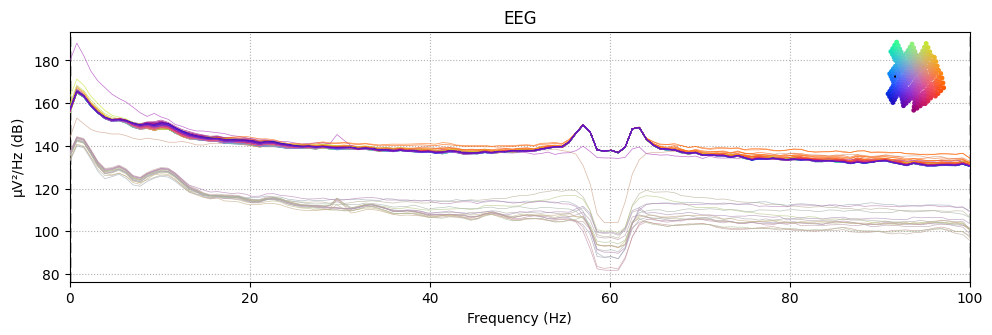

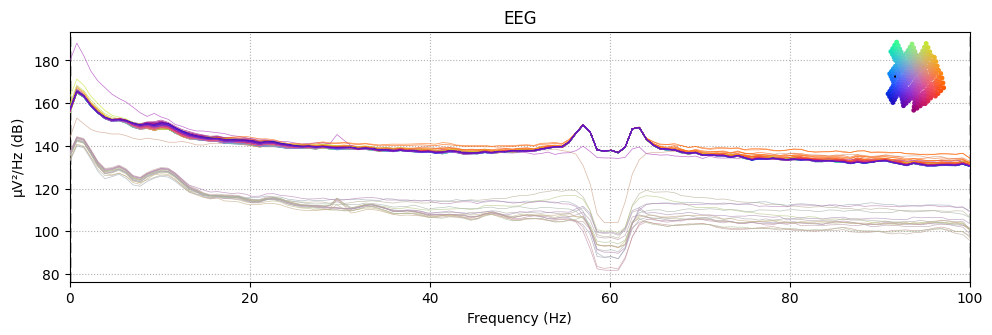

In [8]:
preprocessed_runs = preprocesss_runs_1(raw_runs)
preprocessed_runs[0].plot_psd(fmax=100)

In [11]:
print(preprocessed_runs[0]._data.shape)
remove_bad_channels(preprocessed_runs)
print(preprocessed_runs[0]._data.shape)

(256, 45186)
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 187]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 187]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 187]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 187]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 187]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 187]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69

In [12]:
print(preprocessed_runs[0]._data[0].mean())
preprocesss_runs_2(preprocessed_runs)
print(preprocessed_runs[0]._data[0].mean())


335.59377340607745
28.34098091167247


In [41]:
'''
The features extracted are band power features for the mu and beta bands,
as these frequency bands are associated with motor functions (Miller et al., 2010; Cheyne, 2013).
The EEG data were band-pass filtered for the respective frequency band, and the power was calculated
by squaring each time sample. Then the power was estimated in non-overlapping 0.25 s segments
by averaging the power samples and applying a centered moving average with a 0.75 s window length. 
A centered moving average was used instead of a causal moving average
in order to make the interpretation of results easier, as the latter would introduce time delays.
Again, band power features were log-transformed to improve Gaussianity because non-log-transformed band power features 
are Chisquared distributed. Finally, a power shift compensation was applied, subtracting the mean band power over 
the last 25 s. 
'''
def extract_features(source, plot = False):
    raw = source.copy()

    raw = raw.filter(l_freq=8, h_freq=25)

   
    # Load EEG data
    filtered_eeg_data = raw.get_data()

  

    # Calculate power by squaring each time sample
    power_eeg_data = np.square(filtered_eeg_data)

    # Remove zero values to avoid log(0)
    epsilon = 1e-10
    power_eeg_data[power_eeg_data == 0] = epsilon


  
    ####################
    #  Moving average  #
    ####################
    # In AI we trust
    def moving_average(data, window_size):
        cumsum = np.cumsum(data, axis=-1)
        cumsum[..., window_size:] = cumsum[..., window_size:] - cumsum[..., :-window_size]
        return (cumsum[..., window_size - 1:] / window_size)

    def centered_moving_average(data, window_size):
        half_window = window_size // 2
        cumsum = np.cumsum(data, axis=-1)
        cumsum[..., window_size:] = cumsum[..., window_size:] - cumsum[..., :-window_size]
        return (cumsum[..., window_size - 1:-window_size + 1] / window_size)


    def centered_moving_average_v2(data, window_size):
        half_window = window_size // 2
        cumsum = np.cumsum(data, axis=-1)
        cumsum[..., window_size:] = cumsum[..., window_size:] - cumsum[..., :-window_size]

        # Calculate moving averages
        cma = np.zeros_like(data)
        for i in range(len(data)):
            start = max(0, i - half_window)
            end = min(len(data), i + half_window + 1)
            count = end - start
            cma[i] = cumsum[end - 1] - (cumsum[start - 1] if start > 0 else 0)
            cma[i] /= count

        return cma

    # Define segment parameters
    segment_length = int(0.25 * raw.info['sfreq'])  # 0.25 s segment length 
    window_length = int(0.75 * raw.info['sfreq'])  # 0.75 s window length 

    
    # Remove end samples to ensure segments are of equal length
    num_to_drop = power_eeg_data.shape[-1] % segment_length
    power_eeg_data = power_eeg_data[...,:-num_to_drop] 
    
   
    power_eeg_data = power_eeg_data.reshape(power_eeg_data.shape[0], -1, segment_length)
    power_eeg_data = np.mean(power_eeg_data, axis=-1)

    #print("power_eeg_data", power_eeg_data.shape)
    result = centered_moving_average_v2(power_eeg_data, 3)
    #print("result", result.shape)
   
    # Log-transform the band power features
    result = np.clip(result, a_min=epsilon, a_max=None)
    result = np.log(result)
    
    # Finally, a power shift compensation was applied, subtracting the mean band power over the last 25 s
    baseline = result[...,-int(25*4):]
    baseline = baseline.mean(axis=-1, keepdims=True)
    result = result - baseline


    ### SUPER NOT SURE ABOUT THIS
    #0.25s segments -> 4hz
    raw.resample(4)
    #raw.crop(0.5)
    # print("Shape check")
    # print(result.shape)
    # print(raw._data.shape)
    raw._data = result
    return raw




#print("preprocessed_runs[0].shape: ", preprocessed_runs[0]._data.shape)
featured = extract_features(source=preprocessed_runs[2], plot=False)
print("featured.shape: ", featured._data.shape)

featured.shape:  (256, 939)


In [42]:
features_of_runs = []
for run in raw_runs:
    features_of_runs.append(extract_features(run))

In [33]:
type(preprocessed_runs[0])
preprocessed_runs[0].annotations

<Annotations | 26 segments: Rest (1), index (5), little (5), middle (5), ...>

In [43]:
epochs = []
for run in features_of_runs:
    events, event_ids = mne.events_from_annotations(run)
    # Create epochs from the raw data
    # print("events: ", events[-10:])
    # print("event_ids: ", event_ids)
    # print("run: ", run._data.shape)
    asd = mne.Epochs(run, events, baseline = None, event_id= event_ids, tmin=-0.5, tmax=7, preload=True)
    epochs.append(asd)
epochs = mne.concatenate_epochs(epochs)

In [44]:
epochs.drop_channels(not_ROI_channels)

Number of events,260
Events,Rest: 10index: 50little: 50middle: 50ring: 50thumb: 50
Time range,-0.500 – 7.000 sec
Baseline,-0.500 – 0.000 sec


In [45]:
X = epochs.get_data()
y = epochs.events[:, -1]
print("Samples, channels, timepoints: ", X.shape)
X = X.reshape(X.shape[0], -1)

print(X.shape)
print(y.shape)

Samples, channels, timepoints:  (260, 158, 31)
(260, 4898)
(260,)


In [46]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [47]:
np.unique(y,return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([10, 50, 50, 50, 50, 50], dtype=int64))

In [48]:
# thumb, index, middle, ring, and little finger respectively.

thumb_indices = np.where(y == 2)
index_indices = np.where(y == 3)
middle_indices = np.where(y == 4)
ring_indices = np.where(y == 5)
little_indices = np.where(y == 6)

thumb = X[thumb_indices]
index = X[index_indices]
middle = X[middle_indices]
ring = X[ring_indices]
little = X[little_indices]

In [49]:
middle_vs_ring = np.concatenate((middle, ring), axis=0)
y_middle_vs_ring = np.concatenate((np.zeros(middle.shape[0]), np.ones(ring.shape[0])), axis=0)


X_train, X_test, y_train, y_test = train_test_split(middle_vs_ring, y_middle_vs_ring, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

(90, 4898)
(10, 4898)
(90,)
(10,)


0.4

In [50]:
X = middle_vs_ring
y = y_middle_vs_ring
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf','linear'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                        'C': [0.001, 0.01, 0.1, 1, 10]}]
grid = GridSearchCV(SVC(), tuned_parameters, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)


{'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.5700000000000001
